### This Notebook contains the COMPLETE CODE (with all comments) of my scratch work in Preparing the Bokeh version of the Interactive Choropleth lesson.
- OTHER TEACHERS: you can largely ignore this file completely.
- I didn't want to delete this because it has a lot of valuable visualization / analysis.

### Following this tutorial:
- https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [1]:
# !pip install --upgrade bokeh

In [2]:
# !pip install --upgrade geopandas

### DATA:

Pain in the ass NetCD4 format:
- https://iescoders.com/reading-netcdf4-data-in-python/

In [3]:
# !pip install netcdf4

In [4]:
# import netCDF4 as nc
# import os

# source_files = [f for f in os.listdir() if f.endswith('.nc')]

# file = nc.Dataset(source_files[0])

# file.variables.keys()

# lat = file.variables['latitude']
# lon = file.variables['longitude']
# tg = file.variables['tg']
# time = file.variables['time']

---

### Just going to stick with the Berkeley data cause this data format / size seems extremely tedious and difficult to work with.
- Unless I'm missing something obvious and there are some CSV files lying around??

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os

In [3]:
response = requests.get('http://berkeleyearth.lbl.gov/country-list/')
soup = BeautifulSoup(response.text)
table_rows = soup.find(attrs={'class':'table table-condensed table-hover'}).find_all('tr')
columns = ['Year', 'Month', 'Monthly Anomaly', 'Monthly Uncertainty', 'Annual Anomaly', 'Annual Uncertainty',
           'Five-Year Anomaly', 'Five-Year Uncertainty', 'Ten-Year Anomaly', 'Ten-Year Uncertainty',
           'Twenty-Year Anomaly', 'Twenty-Year Uncertainty']          

FILE = 'all_country_temp_data.csv'
PATH = 'data'
if not FILE in os.listdir(path=PATH):
    df_list = []
    for i in table_rows:
        if i.find('a'):
            url = i.a.get('href')
            name = i.td.text
            print(name)
            country_page = BeautifulSoup(requests.get(url).text)
            txt_file = country_page.find(attrs={'class':'caption text-center'}).find_all('a')[1].get('href')
            df = pd.read_csv(txt_file, sep='\s+', comment='%', names=columns)
            df['Country'] = name
            df_list.append(df) 
    df = pd.concat(df_list)
    df.to_csv(PATH + '/' + FILE)

else:
    df = pd.read_csv(PATH + '/' + FILE, index_col=0)

**Info about the data (from Berkeley site):**

- Temperatures are in Celsius and reported as anomalies relative to the Jan 1951-Dec 1980 average.  
- Uncertainties represent the 95% confidence interval for statistical noise and spatial undersampling effects.  
- Such uncertainties are expected to account for the effects of random noise as well as random biases affecting station trends and random shifts in station baselines.  
- The analysis framework is expected to be robust against most forms of bias; however, the impact of some forms of  possible systematic bias is still being studied.

In [7]:
df.head()

,Year,Month,Monthly Anomaly,Monthly Uncertainty,Annual Anomaly,Annual Uncertainty,Five-Year Anomaly,Five-Year Uncertainty,Ten-Year Anomaly,Ten-Year Uncertainty,Twenty-Year Anomaly,Twenty-Year Uncertainty,Country
0,1838,4,-1.612,2.586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan
1,1838,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan
2,1838,6,-0.860,2.510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan
3,1838,7,0.167,2.883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan
4,1838,8,-0.072,2.992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan


### I suppose we don't really need the annual, 5-year, 10-year, and 20-year columns, so we can drop them for simplicity.

In [8]:
df = df[['Country', 'Year', 'Month', 'Monthly Anomaly', 'Monthly Uncertainty']]

---

Reading in the geographic data

Note: data is not included here in the GitHub repository (cause it's too massive), but it can be downloaded here:
- https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
- click "Download countries" to get a zip file containing the shape file.

---

In [9]:
import geopandas as gpd

In [10]:
SHAPEFILE = '../data/ne_110m_admin_0_countries.shp'

In [11]:
gdf = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

In [12]:
gdf.columns = ['country', 'country_code', 'geometry']

In [13]:
gdf.drop(index = gdf[gdf['country'] == 'Antarctica'].index[0], inplace=True)

### The challenge is to merge the GeoDataFrame with the Climate data (on the country), so that we have everything in one place.
- Of course, this will be tricky since the country names are not spelled exactly the same.
- I could use fuzzy string matching, but it's also possible that some countries will be spelled very differently (due to historical names or extra prefixes and order of words), so if there aren't that many, this might be better left as a manual clean-up.

In [14]:
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [15]:
df.head()

,Country,Year,Month,Monthly Anomaly,Monthly Uncertainty
0,Afghanistan,1838,4,-1.612,2.586
1,Afghanistan,1838,5,NaN,NaN
2,Afghanistan,1838,6,-0.860,2.510
3,Afghanistan,1838,7,0.167,2.883
4,Afghanistan,1838,8,-0.072,2.992


In [16]:
print('Number of countries:')
print(f"GeoData: {len(gdf['country'].unique())}\nClimateData: {len(df['Country'].unique())}")

Number of countries:
GeoData: 176
ClimateData: 237


### Experimenting with Joins:

In [17]:
#Left Join
joined = pd.merge(left=gdf, right=df, how='left', left_on='country', right_on='Country')
print("Countries that didn't match:\n")
print(joined[joined['Country'].isna()]['country'].to_list())

Countries that didn't match:

['United Republic of Tanzania', 'United States of America', 'Democratic Republic of the Congo', 'The Bahamas', 'Falkland Islands', 'East Timor', 'Ivory Coast', 'Republic of the Congo', 'eSwatini', 'Palestine', 'Vanuatu', 'Myanmar', 'Brunei', 'Czechia', 'Northern Cyprus', 'Somaliland', 'Republic of Serbia', 'Kosovo', 'South Sudan']


### Notable Mismatches:
- They were all just slightly different formulations / spellings / names of the same country.


In [18]:
mismatched_names = {'ClimateData':['Tanzania', 'United States', 'Congo (Democratic Republic of the)',
                'Bahamas', 'Falkland Islands (Islas Malvinas)', 'Timor-Leste', "Côte d'Ivoire", 'Congo',
                'Swaziland', 'Palestina', 'Burma', 'Czech Republic', 'Serbia'],
                   'GeoData':['United Republic of Tanzania', 'United States of America', 'Democratic Republic of the Congo',
            'The Bahamas', 'Falkland Islands', 'East Timor', 'Ivory Coast', 'Republic of the Congo',
            'eSwatini', 'Palestine', 'Myanmar', 'Czechia', 'Republic of Serbia'],}
mismatched = pd.DataFrame(data=mismatched_names)
mismatched = mismatched.set_index('ClimateData').to_dict()['GeoData']

Countries with Geographic data that were dropped (since they had no corresponding climate data at all):
- Vanuatu
- Brunei
- Northern Cyprus
- Somaliland
- Kosovo
- South Sudan

In [19]:
df['Country'].replace(to_replace=mismatched, inplace=True)

In [20]:
gdf = pd.merge(left=gdf, right=df, how='left', left_on='country', right_on='Country')
print("Countries that didn't match:\n")
print(gdf[gdf['Country'].isna()]['country'].to_list())
print(f"\n{len(joined['country'].unique())} total countries")

Countries that didn't match:

['Vanuatu', 'Brunei', 'Northern Cyprus', 'Somaliland', 'Kosovo', 'South Sudan']

176 total countries


---

So now we can drop the 6 countries above for which we have geographical shapes but not climate data.

In [21]:
gdf.dropna(subset=['Country'], inplace=True)

And, since we have duplicate columns now, we can delete one of them:

In [22]:
gdf.drop(['Country'], axis=1, inplace=True)

---

### I'm happy with the result: So now we have a final merged GeoDataFrame with 170 countries to plot historical climate data.

In [23]:
print(f"\n{len(gdf['country'].unique())} total countries")


170 total countries


In [24]:
gdf.head()

,country,country_code,geometry,Year,Month,Monthly Anomaly,Monthly Uncertainty
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",1867.0,1.0,-0.239,0.910
1,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",1867.0,2.0,-0.547,1.017
2,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",1867.0,3.0,-0.517,0.959
3,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",1867.0,4.0,-0.125,1.069
4,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",1867.0,5.0,0.091,1.034


Of course, we still have missing data, but that's just from the fact that this is historical climate data for almost every country in the world back to 1750. So a lot of data is naturally missing.

In [25]:
gdf.isna().sum()

country                    0
country_code               0
geometry                   0
Year                       0
Month                      0
Monthly Anomaly        19306
Monthly Uncertainty    19306
dtype: int64

---

This could be a good time to visualize where the data starts for each country, so I can make a reasonable decision on a cutoff point to remove data from years that are very far back (and therefore missing a lot of data).

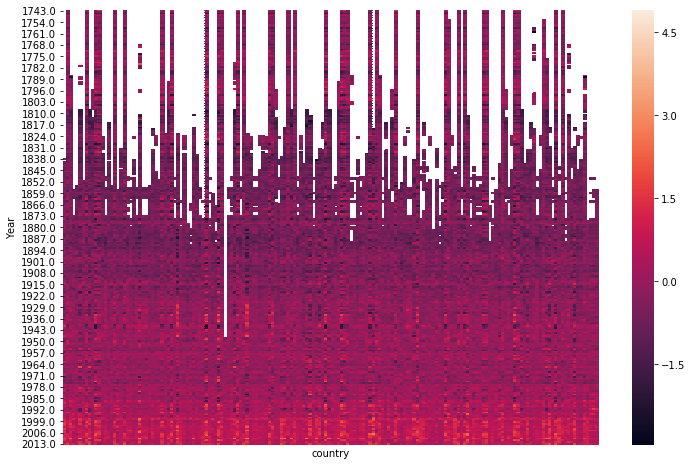

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
sns.heatmap(gdf.pivot_table(values=['Monthly Anomaly'], index=['Year'], columns=['country'])['Monthly Anomaly'],
            xticklabels=False)

Looks like 1900 is a good cut-off point. Looks like there's still a country that has missing values through up to ~1950, but oh well.

In [27]:
gdf = gdf[gdf['Year'] >= 1900]

---

Final things:
- Make the Year and Month columns integers.
- Get rid of country code (don't need it anymore)
- Rename rest of columns to snake_case
- Would also be nice to resample / average the monthly anomaly by country and year (the monthly granularity is a bit overkill)
    - Make this a coding exercise!!

In [28]:
gdf['Year'] = gdf['Year'].astype(int)
gdf['Month'] = gdf['Month'].astype(int)
gdf.rename(columns={"Monthly Anomaly": "monthly_anomaly", "Monthly Uncertainty": "monthly_uncertainty", "Year": "year"},
           inplace=True)
gdf.drop(['country_code'], axis=1, inplace=True)

In [29]:
#let's first extract the countries & geometries (we'll merge them back on later)
polygons = gdf.groupby('country')[['geometry']].first().reset_index()

In [30]:
type(polygons)
### FOR WHATEVER REASON, the groupby converted it back to a regular dataframe (which creates issues later)
### So let's make back into a geodataframe

pandas.core.frame.DataFrame

In [31]:
polygons = gpd.GeoDataFrame(polygons)

In [32]:
#and aggregate the monthly anomalies by year
gdf = gdf.groupby(['country', 'year'])[['monthly_anomaly']].mean().reset_index()

In [33]:
type(gdf)

pandas.core.frame.DataFrame

In [34]:
#and put everything back together
#just be careful with merging data so that we end back up with a GEOdataframe
#see: https://geopandas.readthedocs.io/en/latest/mergingdata.html#merging-data
gdf = pd.merge(polygons, gdf, how='right', on='country')

In [35]:
assert type(gdf) == gpd.geodataframe.GeoDataFrame

And finally, just some sanity checks to see if our data still looks as expected:

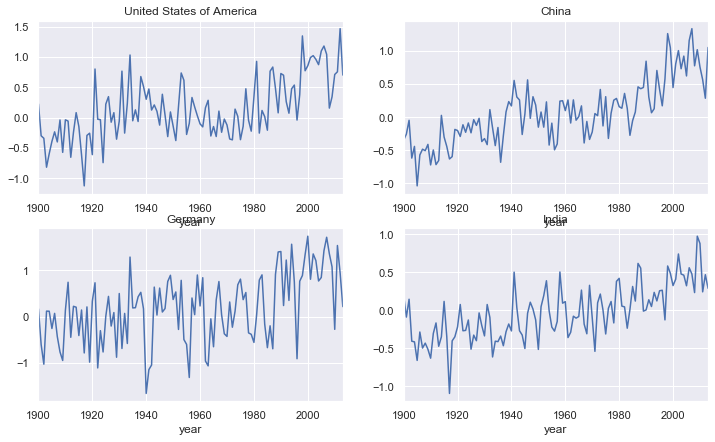

In [36]:
sns.set()
plt.figure(figsize=(12,7))
for i,c in enumerate(['United States of America', 'China', 'Germany', 'India']):
    plt.subplot(2, 2, i+1)
    gdf[gdf['country'] == c].set_index('year')['monthly_anomaly'].plot()
    plt.title(f'{c}')

Text(0.5, 1.0, 'Worldwide Average')

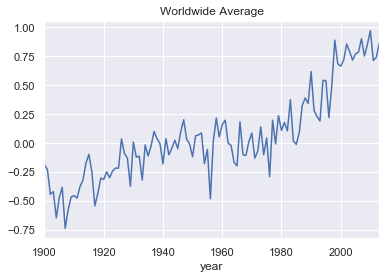

In [37]:
gdf.groupby('year')['monthly_anomaly'].mean().plot()
plt.title('Worldwide Average')

### Getting Bokeh working:
- Let's first try getting it working for a single year (2000) as a test, then we can go back to the main GeoDataFrame.

In [38]:
gdf_2000 = gdf[gdf['year'] == 2000]

In [39]:
# No missing data, nice.
gdf_2000.isna().sum()

country            0
geometry           0
year               0
monthly_anomaly    0
dtype: int64

`As worded in the tutorial:` **The merged file is a GeoDataframe object that can be rendered using geopandas module. However, since we want to incorporate data visualization interactivity, we will use Bokeh library.**
- Bokeh consumes GeoJSON format which represents geographical features with JSON. 
- GeoJSON describes points, lines and polygons (called Patches in Bokeh) as a collection of features. 
- We therefore need to convert the merged file to GeoJSON format.

In [40]:
import json
#Read data to json.
json_2000 = gdf_2000.to_json()
### GeoDataFrames render themselves seamlessly in GeoJSON format!

### Now the Bokeh stuff:

In [41]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

In [42]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_2000)

In [43]:
palette = brewer['Oranges'][8]
palette = brewer['RdBu'][9]
#built-in color palettes in Bokeh. 
#In this example, we're arbitrarily taking the 8th palette of hex-values from the 'Oranges' spectrum.
#check out all the options: https://docs.bokeh.org/en/latest/docs/reference/palettes.html#brewer-palettes

In [44]:
#Reverse color order so that dark orange / red is highest Monthly Anomaly value.
# palette = palette[::-1]

In [45]:
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
#fixing the color range from MIN VALUE of Monthly Anomaly (white) to MAX VALUE of Monthly Anomaly (red).
color_mapper = LinearColorMapper(palette = palette,
                                 low = -3,
                                 high = 3, #Arbitrary ranges. Making it symmetrical so that zero (no anomaly) is neutral color.
                                 nan_color = '#d9d9d9')




In [46]:
#Define custom tick labels for color bar.
# tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}

In [47]:
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=8,
                     width = 500,
                     height = 20,
                     border_line_color=None,
                     location = (0,0),
                     orientation = 'horizontal',
#                      major_label_overrides = tick_labels
                    )

In [48]:
color_bar

ColorBar(id='1003', ...)

In [49]:
#Create figure object.
p = figure(title = 'Avg. Monthly Temperature Anomaly for Year 2000',
           plot_height = 600,
           plot_width = 950,
           toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. Like actually add the map to the canvas.
p.patches('xs',
          'ys',
          source = geosource,
          fill_color = {'field' :'monthly_anomaly', 'transform':color_mapper},
          line_color = 'black',
          line_width = 0.25,
          fill_alpha = 1)

#Specify figure layout. Add the color bar
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

show(p)

Loading BokehJS ...

---

### Alright, now let's add some interactivity!
- Our goal is to create a dynamic map that updates data based on year selected in the range of 1900–2013. 
- We will also add a hover tool which allows user to view details by just hovering the mouse over a specific country.
- Bokeh provides an extensive set of widgets and tools and makes it very simple to create rich, interactive visualizations. We will define a few functions and reuse a major chunk of code written for creating the static map.

In [50]:
#Define function that returns json_data for year selected by user.
    
def get_geojson(yr):
    """Input a year (int) and return corresponding slice of the GeoDataFrame, converted to GeoJSON"""
    gdf_year = gdf[gdf['year'] == yr]
    gdf_year['monthly_anomaly'].fillna('No data', inplace = True) #this will register as a null value in the map
    json_data = gdf_year.to_json()
    return json_data

In [51]:
#Same code from earlier (repeating just for refresher / clarity)
geosource = GeoJSONDataSource(geojson = get_geojson(1900))
palette = brewer['Oranges'][8]
palette = brewer['RdBu'][9]
# palette = palette[::-1]
color_mapper = LinearColorMapper(palette = palette,
                                 low = -3,
                                 high = 3, #Arbitrary ranges. Making it symmetrical so that zero (no anomaly) is neutral color.
                                 nan_color = '#d9d9d9')

/anaconda3/envs/dl/lib/python3.6/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [52]:
### NEW! --> #Add hover tool
from bokeh.models import Slider, HoverTool

# Add tooltip (name, field) pairs to the tool.
# The name is what's gonna show up on the plot, and the field with the @ symbol is the name of the GDF column.
hover = HoverTool(tooltips = [ ('Country','@country'), ('Temp. Anomaly', '@monthly_anomaly')])

In [53]:
#more same code from earlier 

color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=8,
                     width = 500,
                     height = 20,
                     border_line_color=None,
                     location = (0,0),
                     orientation = 'horizontal')

p = figure(title = 'Avg. Monthly Temperature Anomaly for Year 1900',
           plot_height = 600,
           plot_width = 950,
           toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.patches('xs',
          'ys',
          source = geosource,
          fill_color = {'field' :'monthly_anomaly', 'transform':color_mapper},
          line_color = 'black',
          line_width = 0.25,
          fill_alpha = 1)

p.add_layout(color_bar, 'below')


In [54]:
### NEW! ->> Make a slider object: slider 
slider = Slider(title = 'Year', start = 1900, end = 2013, step = 1, value = 1900)

Now, the really cool features about the slider is that you can put in your own, custom callback function!!
- So basically, all we have to do is write our own python function that does whatever we want to happen everytime the slider is adjusted.

In [55]:
# Make a slider object: slider 
# https://docs.bokeh.org/en/latest/docs/reference/models/widgets.sliders.html

def update_plot(attr, old, new):
    """Change properties / attributes of the datasource and title depending on slider value / position."""
    yr = slider.value
    new_data = get_geojson(yr)
    geosource.geojson = new_data
    p.title.text = f'Avg. Monthly Temperature Anomaly for Year {yr}'
      
slider.on_change('value', update_plot)


In [56]:
from bokeh.layouts import widgetbox, column
from bokeh.io import curdoc
# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)

In [57]:
#Display plot inline in Jupyter notebook
output_notebook()

#Display plot with layout thingy
show(layout)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



### Yay! So everything works except it doesn't like our use of python-based callbacks apparently (boo!)
- So basically, since we're not super cool JavaScript devs, we need our own separate backend server to run it.

In the terminal, run:

``bokeh serve --show interactive_climate_map_FULL.ipynb``

---
---
---

### FINAL NOTES:
- In preparing this activity into an exercise, I'm going to have the students use an already pre-processed, pre-scraped dataset with the Monthly Anomaly data so that we don't have to waste any time with manual data cleaning.
- I will be giving them a CSV file of the data that's already everything after 1900, with the names already cleaned.
- But since I also want the students to read in the Shape file and do some merging themselves (as good data wrangling practice), I need to recreate the dataframe to an earlier state....

In [4]:
df = pd.read_csv(PATH + '/' + FILE, index_col=0)

In [5]:
df = df[['Country', 'Year', 'Month', 'Monthly Anomaly', 'Monthly Uncertainty']]

In [6]:
mismatched_names = {'ClimateData':['Tanzania', 'United States', 'Congo (Democratic Republic of the)',
                'Bahamas', 'Falkland Islands (Islas Malvinas)', 'Timor-Leste', "Côte d'Ivoire", 'Congo',
                'Swaziland', 'Palestina', 'Burma', 'Czech Republic', 'Serbia'],
                   'GeoData':['United Republic of Tanzania', 'United States of America', 'Democratic Republic of the Congo',
            'The Bahamas', 'Falkland Islands', 'East Timor', 'Ivory Coast', 'Republic of the Congo',
            'eSwatini', 'Palestine', 'Myanmar', 'Czechia', 'Republic of Serbia'],}
mismatched = pd.DataFrame(data=mismatched_names)
mismatched = mismatched.set_index('ClimateData').to_dict()['GeoData']

In [7]:
df['Country'].replace(to_replace=mismatched, inplace=True)

In [8]:
df = df[df['Year'] >= 1900]

In [9]:
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)
df.rename(columns={"Monthly Anomaly": "monthly_anomaly",
                   "Monthly Uncertainty": "monthly_uncertainty",
                   "Year": "year",
                   "Month": "month",
                   "Country": "country"},
                   inplace=True)

In [11]:
df.to_csv('data/all_country_temp_data_CLEAN.csv', index=False)

---
---
---